# Visual Analytics Project

- Kilian Mütz (79561) und Timo Gerstenhauer ()

## Ein interaktives explainable AI (XAI) Dashboard zur Anomalieerkennung bei Hotelbuchungen 

### Business Understanding

- "Hotel booking demand dataset"
- Fokus auf das Untersuchungsobjekt "Resort-Hotel H1" an der Algravenküste Portugals
- Der Datensatz umfasst den Zeitraum vom 01.07.2015 bis zum 31.08.2017

### Data Understanding

- Der Datensatz wurde als CSV "H1" geladen
- Es existieren 31 Variablen mit ~40.000 Beobachtungen

#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
#test

#### Load Data

In [11]:
df = pd.read_csv("H1.csv")

#### Übersicht

In [13]:
print(df.shape)

(40060, 31)


In [14]:
print(df.head())

   IsCanceled  LeadTime  ArrivalDateYear ArrivalDateMonth  \
0           0       342             2015             July   
1           0       737             2015             July   
2           0         7             2015             July   
3           0        13             2015             July   
4           0        14             2015             July   

   ArrivalDateWeekNumber  ArrivalDateDayOfMonth  StaysInWeekendNights  \
0                     27                      1                     0   
1                     27                      1                     0   
2                     27                      1                     0   
3                     27                      1                     0   
4                     27                      1                     0   

   StaysInWeekNights  Adults  Children  ...      DepositType        Agent  \
0                  0       2         0  ...  No Deposit              NULL   
1                  0       2         0  

In [15]:
print(df.dtypes)

IsCanceled                       int64
LeadTime                         int64
ArrivalDateYear                  int64
ArrivalDateMonth                object
ArrivalDateWeekNumber            int64
ArrivalDateDayOfMonth            int64
StaysInWeekendNights             int64
StaysInWeekNights                int64
Adults                           int64
Children                         int64
Babies                           int64
Meal                            object
Country                         object
MarketSegment                   object
DistributionChannel             object
IsRepeatedGuest                  int64
PreviousCancellations            int64
PreviousBookingsNotCanceled      int64
ReservedRoomType                object
AssignedRoomType                object
BookingChanges                   int64
DepositType                     object
Agent                           object
Company                         object
DaysInWaitingList                int64
CustomerType             

### Data Preparation

#### Rationalisierung 

- Variablen mit überwiegend NULL oder irrelevanten IDs eliminieren

In [19]:
df = df.drop(columns=['Company', 'Agent', 'ReservationStatusDate'], errors='ignore')

- Encoding kategorischer features

In [21]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
encoders = {}

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

#### Zielvariable

In [23]:
target = df['IsCanceled']
features = df.drop(columns=['IsCanceled'])

#### Standardisierung numerischer features

In [25]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

#### Principal Component Analysis auf zwei Dimensionen

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

#### Erste Visualisierung

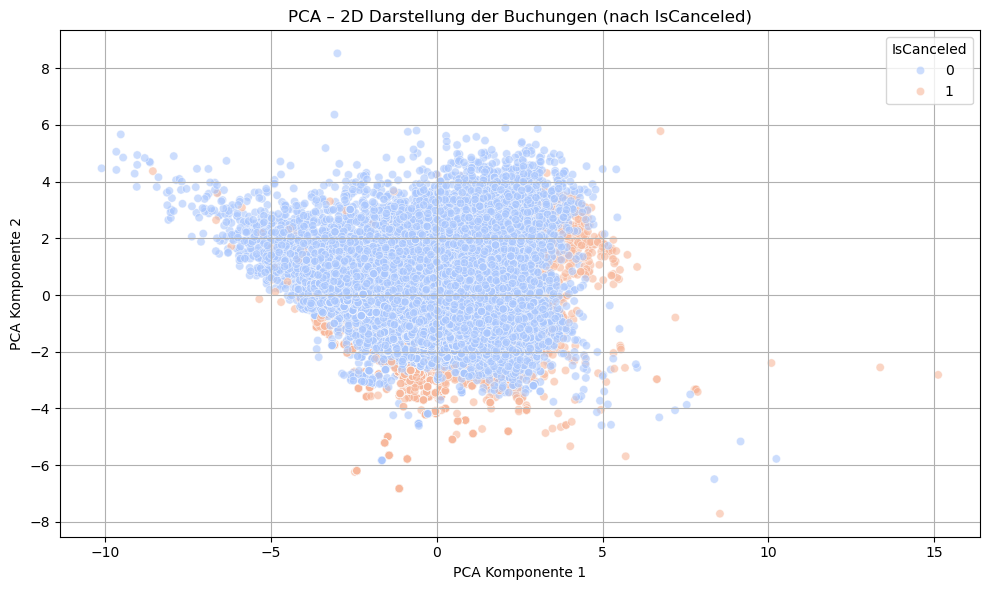

In [29]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=target, palette='coolwarm', alpha=0.6)
plt.title("PCA – 2D Darstellung der Buchungen (nach IsCanceled)")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="IsCanceled")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Alternativ PCA auf drei Dimensionen

In [31]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

#### 3D Visualisierung

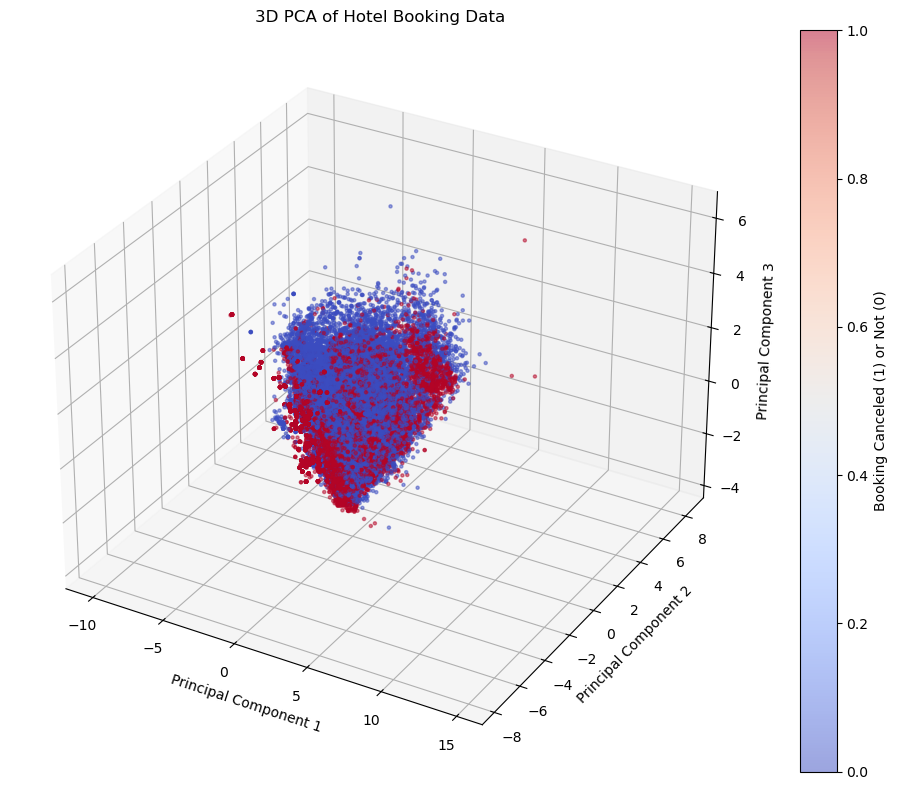

In [33]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    X_pca[:, 2],
    c=target,
    cmap='coolwarm',
    alpha=0.5,
    s=5
)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA of Hotel Booking Data')

legend = plt.colorbar(scatter)
legend.set_label('Booking Canceled (1) or Not (0)')

plt.tight_layout()

In [34]:
pca_df = pd.DataFrame(

    data=X_pca, 
    columns=['PC1', 'PC2', 'PC3']
)
pca_df['IsCanceled']=target.values

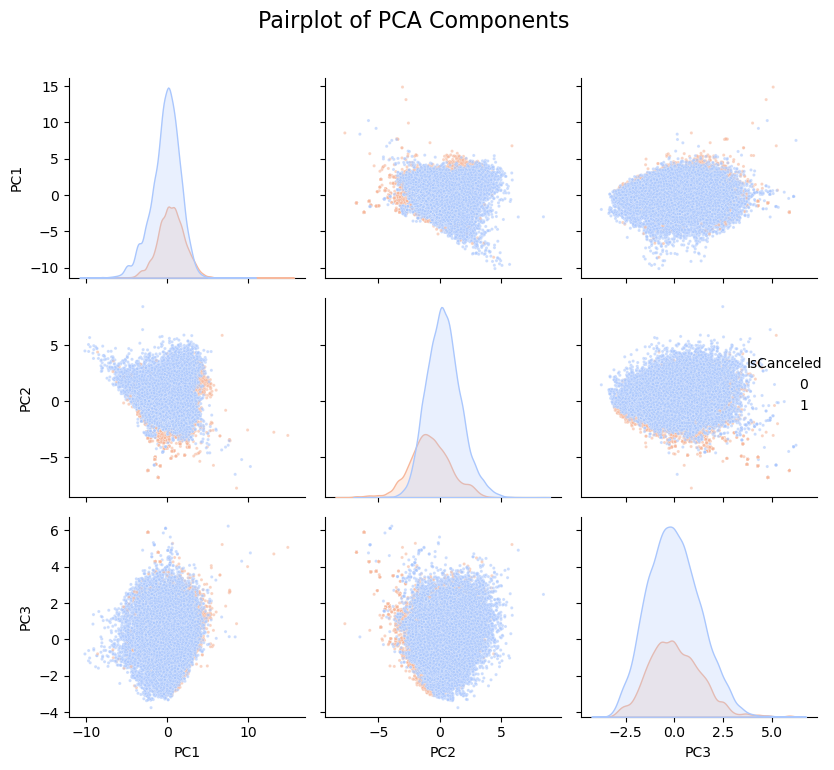

In [35]:
sns.pairplot(pca_df, hue='IsCanceled', palette='coolwarm', 
             diag_kind='kde', plot_kws={'alpha': 0.6, 's': 5})

plt.suptitle('Pairplot of PCA Components', y=1.02, fontsize=16)
plt.tight_layout()

### Data Modeling

#### Isolation Forest

In [38]:
from sklearn.ensemble import IsolationForest

Training

In [70]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

IsolationForest(contamination=0.05, random_state=42)

Vorhersage

In [42]:
df['Anomaly'] = iso_forest.predict(X_scaled)

-1 = Anomalie; 
1 = Normal; für bessere Lesbarkeit auf 0/1 gemappt

In [44]:
df['Anomaly'] = df['Anomaly'].map({1: 0, -1: 1})

Visualisierung

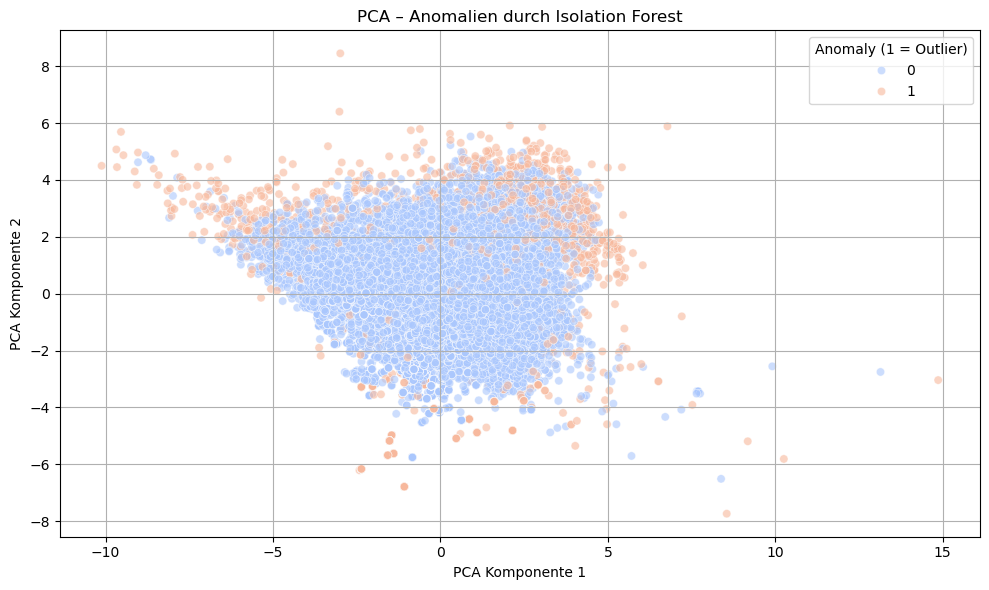

In [46]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['Anomaly'], palette='coolwarm', alpha=0.6)
plt.title("PCA – Anomalien durch Isolation Forest")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="Anomaly (1 = Outlier)")
plt.grid(True)
plt.tight_layout()
plt.show()

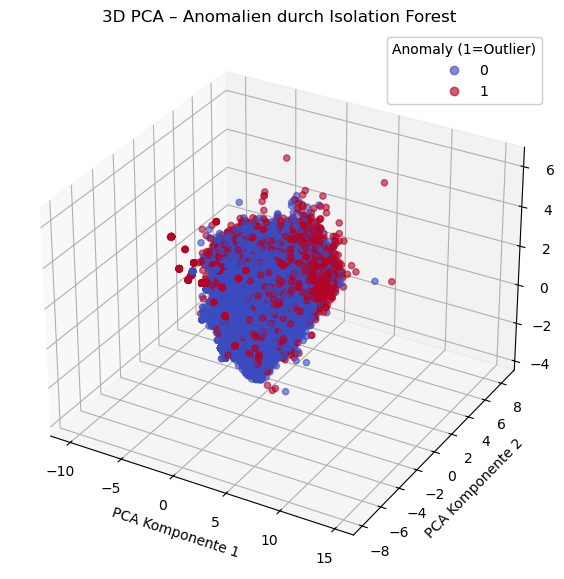

In [47]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                     c=df['Anomaly'], cmap='coolwarm', alpha=0.6)

ax.set_title("3D PCA – Anomalien durch Isolation Forest")
ax.set_xlabel("PCA Komponente 1")
ax.set_ylabel("PCA Komponente 2")
ax.set_zlabel("PCA Komponente 3")
legend1 = ax.legend(*scatter.legend_elements(), title="Anomaly (1=Outlier)")
ax.add_artist(legend1)
plt.show()


### Data Evaluation

#### Anomalien analysieren

In [50]:
#Alle Anomalien
anomalies = df[df['Anomaly'] == 1]
normals = df[df['Anomaly'] == 0]

print(f"Anzahl Anomalien: {anomalies.shape[0]}")
print(f"Anzahl normale Buchungen: {normals.shape[0]}")

Anzahl Anomalien: 2003
Anzahl normale Buchungen: 38057


In [51]:
#Überblick
print("\n--- Übersicht: Anomalien (Statistik) ---")
print(anomalies.describe())


--- Übersicht: Anomalien (Statistik) ---
        IsCanceled     LeadTime  ArrivalDateYear  ArrivalDateMonth  \
count  2003.000000  2003.000000      2003.000000       2003.000000   
mean      0.345482   115.648028      2016.124314          5.263105   
std       0.475644   109.834552         0.828454          3.806400   
min       0.000000     0.000000      2015.000000          0.000000   
25%       0.000000    16.000000      2015.000000          1.000000   
50%       0.000000    80.000000      2016.000000          5.000000   
75%       1.000000   203.000000      2017.000000          9.000000   
max       1.000000   709.000000      2017.000000         11.000000   

       ArrivalDateWeekNumber  ArrivalDateDayOfMonth  StaysInWeekendNights  \
count            2003.000000            2003.000000           2003.000000   
mean               29.023964              14.632052              1.658512   
std                12.678867               9.270058              1.870485   
min                

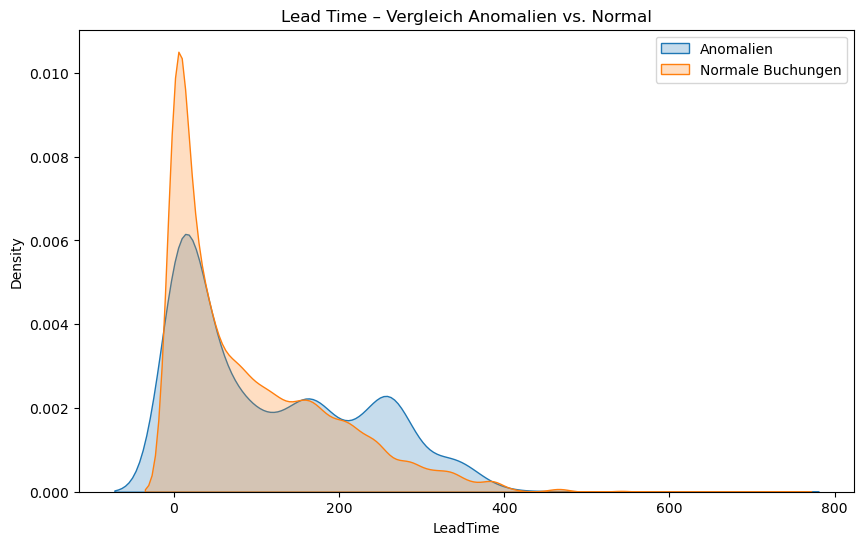

In [52]:
#Vergleich: Anomalien vs. normale Buchungen bei Lead Time
plt.figure(figsize=(10,6))
sns.kdeplot(anomalies['LeadTime'], label='Anomalien', fill=True)
sns.kdeplot(normals['LeadTime'], label='Normale Buchungen', fill=True)
plt.title('Lead Time – Vergleich Anomalien vs. Normal')
plt.legend()
plt.show()

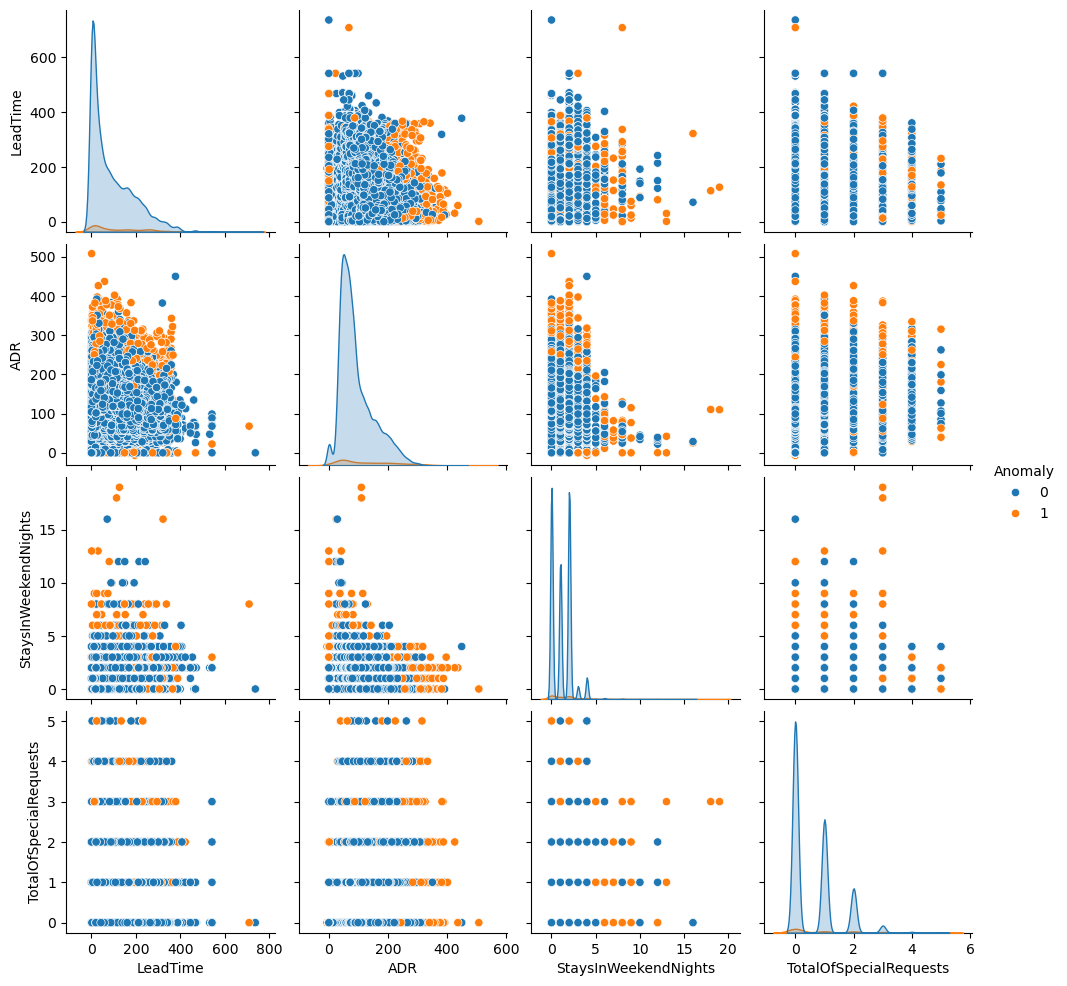

In [53]:
#Vergleich mehrerer features
sns.pairplot(df, hue='Anomaly', vars=['LeadTime', 'ADR', 'StaysInWeekendNights', 'TotalOfSpecialRequests'])
plt.show()

In [54]:
#Top5 Anomalien
print("\n--- Einzelne Anomalien ---")
print(anomalies.head(5))


--- Einzelne Anomalien ---
     IsCanceled  LeadTime  ArrivalDateYear  ArrivalDateMonth  \
30            0       118             2015                 5   
87            1        79             2015                 5   
125           0        32             2015                 5   
140           0        44             2015                 5   
154           0         8             2015                 5   

     ArrivalDateWeekNumber  ArrivalDateDayOfMonth  StaysInWeekendNights  \
30                      27                      1                     4   
87                      27                      3                     6   
125                     27                      4                     0   
140                     28                      5                     2   
154                     28                      5                     4   

     StaysInWeekNights  Adults  Children  ...  AssignedRoomType  \
30                  10       1         0  ...                 0   
87

#### Interpretation

In [56]:
print(f"Anzahl Anomalien: {anomalies.shape[0]}")
print(f"Anzahl normale Buchungen: {normals.shape[0]}")
print(f"Anteil Anomalien: {anomalies.shape[0] / df.shape[0]:.2%}")

Anzahl Anomalien: 2003
Anzahl normale Buchungen: 38057
Anteil Anomalien: 5.00%


In [57]:
anomalies.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,AssignedRoomType,BookingChanges,DepositType,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,Anomaly
count,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,...,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.000000,2003.0
mean,0.345482,115.648028,2016.124314,5.263105,29.023964,14.632052,1.658512,4.452821,1.989516,0.555667,...,3.652022,0.841737,0.151273,1.878682,2.093859,135.170889,0.341488,0.920619,0.672491,1.0
std,0.475644,109.834552,0.828454,3.806400,12.678867,9.270058,1.870485,4.322090,1.625653,0.810934,...,2.738199,1.331781,0.382669,15.475054,0.552152,97.722150,0.538443,1.151461,0.488200,0.0
min,0.000000,0.000000,2015.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,1.0
25%,0.000000,16.000000,2015.000000,1.000000,19.500000,6.000000,0.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,48.500000,0.000000,0.000000,0.000000,1.0
50%,0.000000,80.000000,2016.000000,5.000000,31.000000,15.000000,1.000000,3.000000,2.000000,0.000000,...,4.000000,0.000000,0.000000,0.000000,2.000000,117.750000,0.000000,0.000000,1.000000,1.0
75%,1.000000,203.000000,2017.000000,9.000000,38.000000,23.000000,2.000000,5.000000,2.000000,1.000000,...,6.000000,1.000000,0.000000,0.000000,2.000000,207.000000,1.000000,2.000000,1.000000,1.0
max,1.000000,709.000000,2017.000000,11.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,...,10.000000,17.000000,2.000000,185.000000,3.000000,508.000000,8.000000,5.000000,2.000000,1.0


In [58]:
normals.describe()

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,StaysInWeekendNights,StaysInWeekNights,Adults,Children,...,AssignedRoomType,BookingChanges,DepositType,DaysInWaitingList,CustomerType,ADR,RequiredCarParkingSpaces,TotalOfSpecialRequests,ReservationStatus,Anomaly
count,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,...,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.000000,38057.0
mean,0.274063,91.466616,2016.121292,5.317261,27.041753,15.883832,1.165147,3.059043,1.860709,0.106209,...,2.063773,0.258822,0.044670,0.456657,2.098983,92.836195,0.127362,0.603936,0.740284,0.0
std,0.446047,96.429811,0.716339,3.484874,14.064966,8.858613,1.091141,2.301554,0.609870,0.404889,...,2.030435,0.667353,0.221793,6.737142,0.610377,58.153948,0.334876,0.789041,0.454550,0.0
min,0.000000,0.000000,2015.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,10.000000,2016.000000,2.000000,15.000000,8.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,50.170000,0.000000,0.000000,0.000000,0.0
50%,0.000000,56.000000,2016.000000,5.000000,28.000000,16.000000,1.000000,3.000000,2.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,2.000000,75.000000,0.000000,0.000000,1.000000,0.0
75%,1.000000,152.000000,2017.000000,8.000000,38.000000,24.000000,2.000000,5.000000,2.000000,0.000000,...,3.000000,0.000000,0.000000,0.000000,2.000000,121.000000,0.000000,1.000000,1.000000,0.0
max,1.000000,737.000000,2017.000000,11.000000,53.000000,31.000000,16.000000,40.000000,50.000000,3.000000,...,8.000000,16.000000,2.000000,185.000000,3.000000,450.000000,3.000000,5.000000,2.000000,0.0


In [59]:
print("--- Anomalien: CustomerType Verteilung ---")
print(anomalies['CustomerType'].value_counts(normalize=True))

print("--- Anomalien: Stornierungsrate ---")
print(anomalies['IsCanceled'].value_counts(normalize=True))

--- Anomalien: CustomerType Verteilung ---
CustomerType
2    0.779331
3    0.172741
0    0.030954
1    0.016975
Name: proportion, dtype: float64
--- Anomalien: Stornierungsrate ---
IsCanceled
0    0.654518
1    0.345482
Name: proportion, dtype: float64


### Explainable AI 

#### SHAP

In [ ]:
import shap

Isolation Forest ohne PCA, für bessere XAI Anwendung

In [74]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_scaled)

IsolationForest(contamination=0.05, random_state=42)

In [78]:
explainer = shap.TreeExplainer(iso_forest)
shap_values = explainer.shap_values(X_scaled)

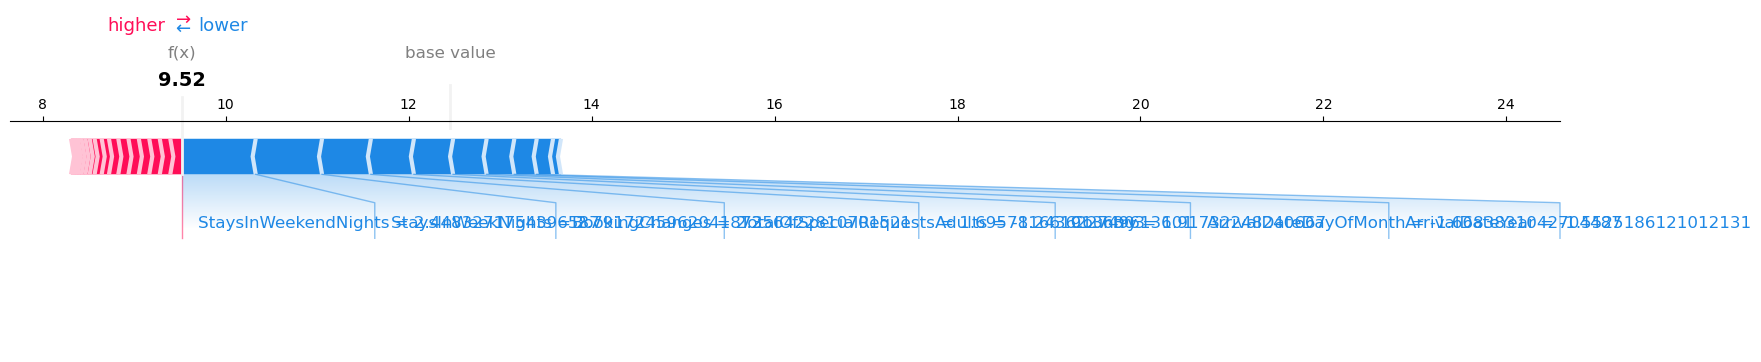

In [80]:
# Force Plot für eine einzelne Anomalie
anomaly_index = df[df['Anomaly'] == 1].index[0]
shap.force_plot(explainer.expected_value, shap_values[anomaly_index,:], X_scaled[anomaly_index,:], feature_names=features.columns, matplotlib=True)

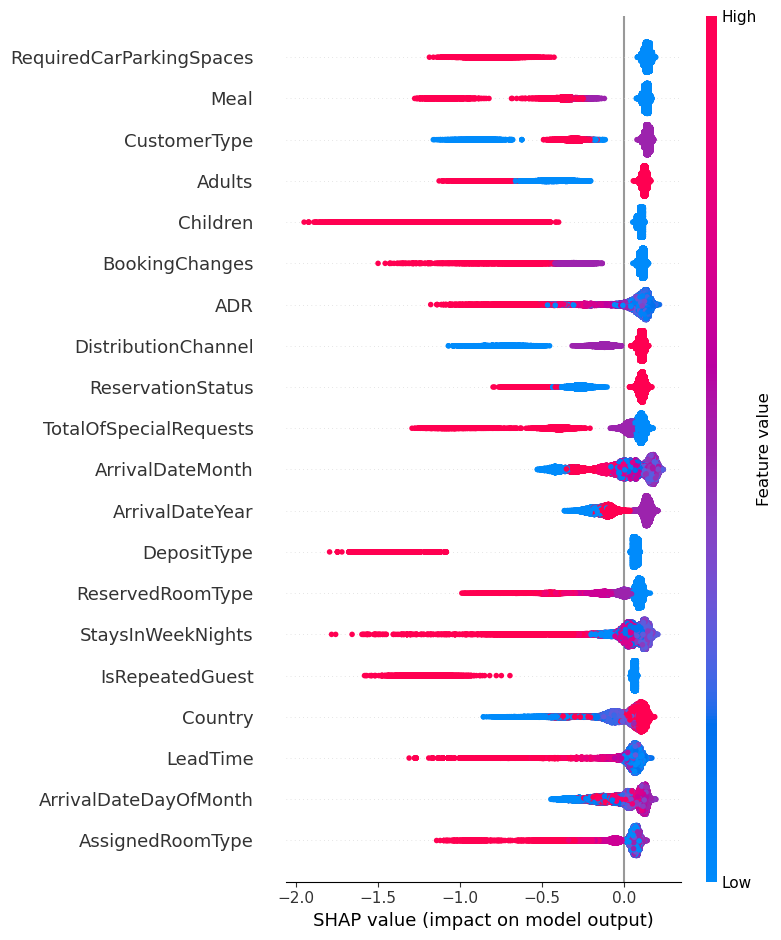

In [82]:
# Summary Plot für alle Buchungen
shap.summary_plot(shap_values, features, feature_names=features.columns)

#### LIME

In [91]:
import lime
import lime.lime_tabular

In [93]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_scaled,
    feature_names=features.columns.tolist(),
    class_names=['Normal', 'Anomaly'],
    mode='classification',
    verbose=True,
    random_state=42
)

Eine Anomalie erklären

In [95]:
anomaly_index = df[df['Anomaly'] == 1].index[0]

In [100]:
# predict_proba muss simuliert werden, weil Isolation Forest nicht klassisch ist
def predict_proba_isoforest(X):
    preds = iso_forest.decision_function(X)
    preds = (preds - preds.min()) / (preds.max() - preds.min())  # Normierung auf [0,1]
    preds = np.vstack([1 - preds, preds]).T
    return preds

In [102]:
lime_exp = lime_explainer.explain_instance(
    X_scaled[anomaly_index],
    predict_proba_isoforest,
    num_features=10
)

Intercept -0.6984727187006439
Prediction_local [0.60367165]
Right: 0.3813579347432229


In [104]:
lime_exp.show_in_notebook(show_table=True)